In [173]:
import mdtraj as md
import pyemma
import numpy as np
import msmexplorer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook')
from msmbuilder.io.sampling import sample_dimension

In [2]:
apo1 = md.load('apo_aligned_md1.nc', top='amber.apo.parm7')
apo2 = md.load('apo_aligned_md2.nc', top='amber.apo.parm7')
apo3 = md.load('apo_aligned_md3.nc', top='amber.apo.parm7')
holo1 = md.load('holo_aligned_md1.nc', top='amber.holo.parm7')
holo2 = md.load('holo_aligned_md2.nc', top='amber.holo.parm7')
# holo3 = md.load('holo_aligned_md3.nc', top='amber.holo.parm7') # missing?

In [131]:
apo1

<mdtraj.Trajectory with 2020 frames, 1874 atoms, 115 residues, and unitcells at 0x1a11dedcc0>

In [3]:
len(apo1), len(apo2), len(apo3), len(holo1), len(holo2)

(2020, 2189, 4028, 2040, 2040)

In [4]:
# trajectories are 2/4 microseconds, so frames are every 1 ns

In [5]:
apo1_contacts = md.compute_contacts(apo1)
apo2_contacts = md.compute_contacts(apo2)
apo3_contacts = md.compute_contacts(apo3)
holo1_contacts = md.compute_contacts(holo1)
holo2_contacts = md.compute_contacts(holo2)

In [6]:
apo_tica = pyemma.coordinates.tica([apo1_contacts[0], apo2_contacts[0], apo3_contacts[0]], lag=5, kinetic_map=False, commute_map=True, var_cutoff=1)

HBox(children=(HBox(children=(Label(value='calculate covariances'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=3), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [7]:
# how many tics for 95% kinetic content (for commute map; which is different from kinetic variance (var_cutoff) for kinetic map)

In [24]:
np.argwhere(np.cumsum(apo_tica.timescales) / np.sum(apo_tica.timescales) > 0.95)[0,0]

3746

In [25]:
Y = apo_tica.get_output()

HBox(children=(HBox(children=(Label(value='getting output of TICA'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=3), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [29]:
Y = [x[:,:3747] for x in Y]

In [31]:
kmeans = pyemma.coordinates.cluster_kmeans(Y, k=100)

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

05-06-19 13:58:23 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 10 steps.


In [44]:
dtrajs = kmeans.get_output()
dtrajs = [np.concatenate(x) for x in dtrajs]

HBox(children=(HBox(children=(Label(value='getting output of KmeansClustering'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=3), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [49]:
np.save('apo_100micro_dtrajs', dtrajs)

In [42]:
# plot tica landscape - later we'll plot clusters colored by metastable sets on it

In [35]:
tica_proj_concat = np.concatenate(Y)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


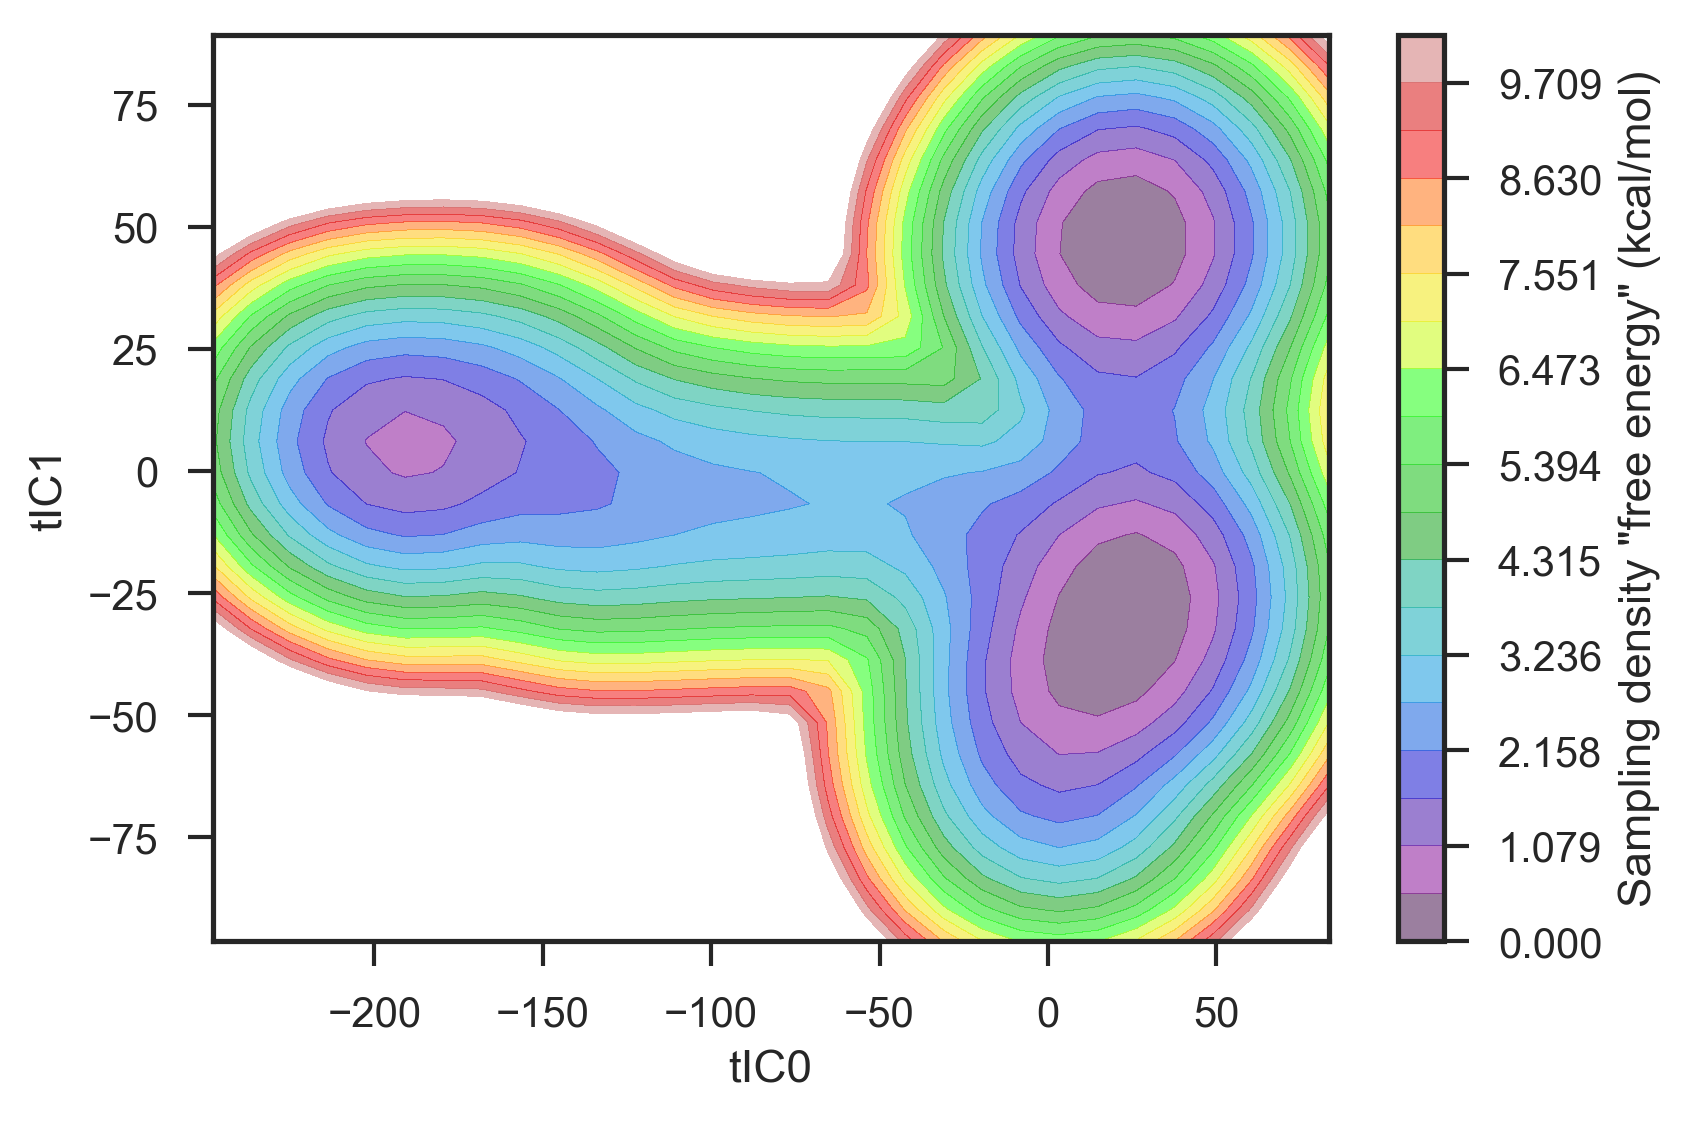

In [41]:
i=0
j=1

plot_data = msmexplorer.plot_free_energy(tica_proj_concat, obs=(i,j), cbar=True, return_data=True)
plt.close()

# plot initial conformations on it now
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
ax.grid(False)
ax.set_xlabel('tIC0')
ax.set_ylabel('tIC1')
vmin = -1E-12
vmax = np.percentile(plot_data[1][2], 50)
n_levels = 20
alpha = 0.5
im = ax.contourf(plot_data[1][0], plot_data[1][1], plot_data[1][2] - plot_data[1][2].min(),cmap=plt.get_cmap('spectral'),
                             levels=np.linspace(vmin, vmax, n_levels), alpha=alpha,
                             zorder=1, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Sampling density "free energy" (kcal/mol)')

#plt.savefig('tica/tics_0_1.png', dpi=300)
plt.show()

In [43]:
# MSM timescales

In [47]:
its = pyemma.msm.its(dtrajs)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=18), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

05-06-19 14:04:16 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Ignored error during estimation: Active set is empty. Cannot estimate MSM.
05-06-19 14:04:16 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[7] WARNING  Ignored error during estimation: Active set is empty. Cannot estimate MSM.
05-06-19 14:04:16 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[8] WARNING  Estimation has failed at lagtimes: [1065.         1372.83333333]. Details:
['Error at lag time 1065.0: Active set is empty. Cannot estimate MSM.',
 'Error at lag time 1372.8333333333333: Active set is empty. Cannot estimate '
 'MSM.']
05-06-19 14:04:16 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[8] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


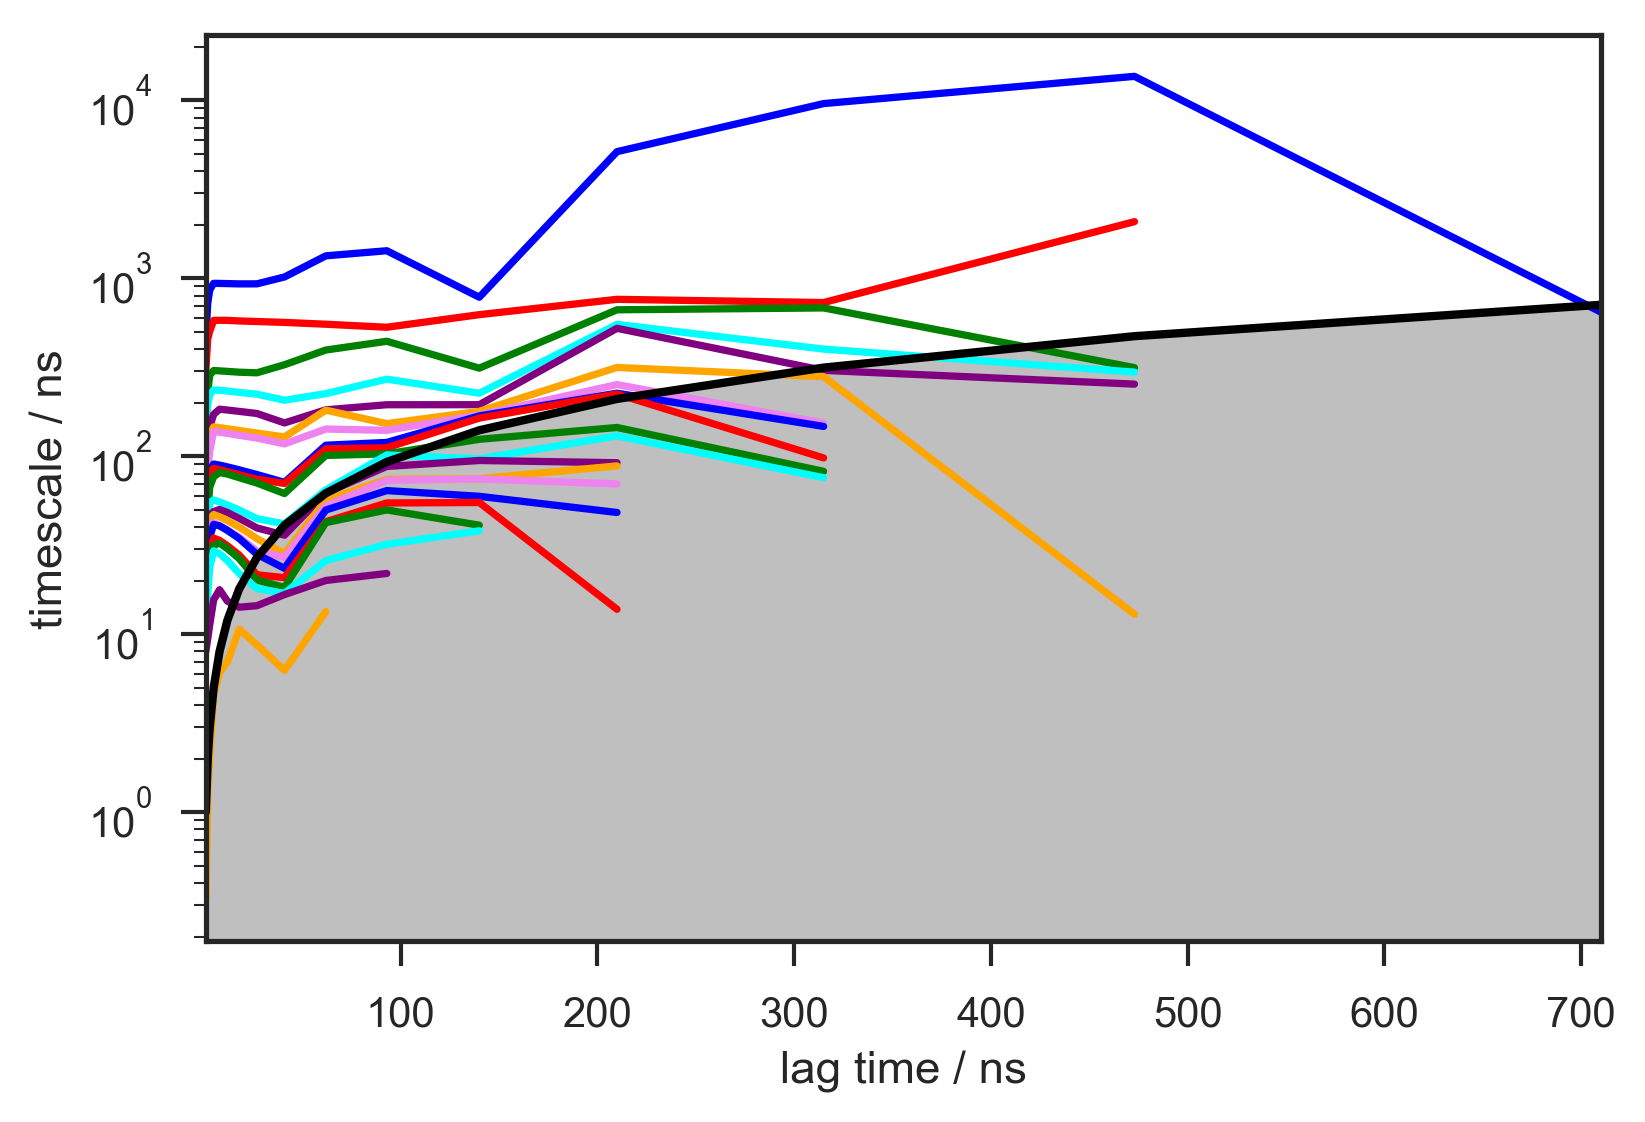

In [53]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(its, dt=1, units='ns')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


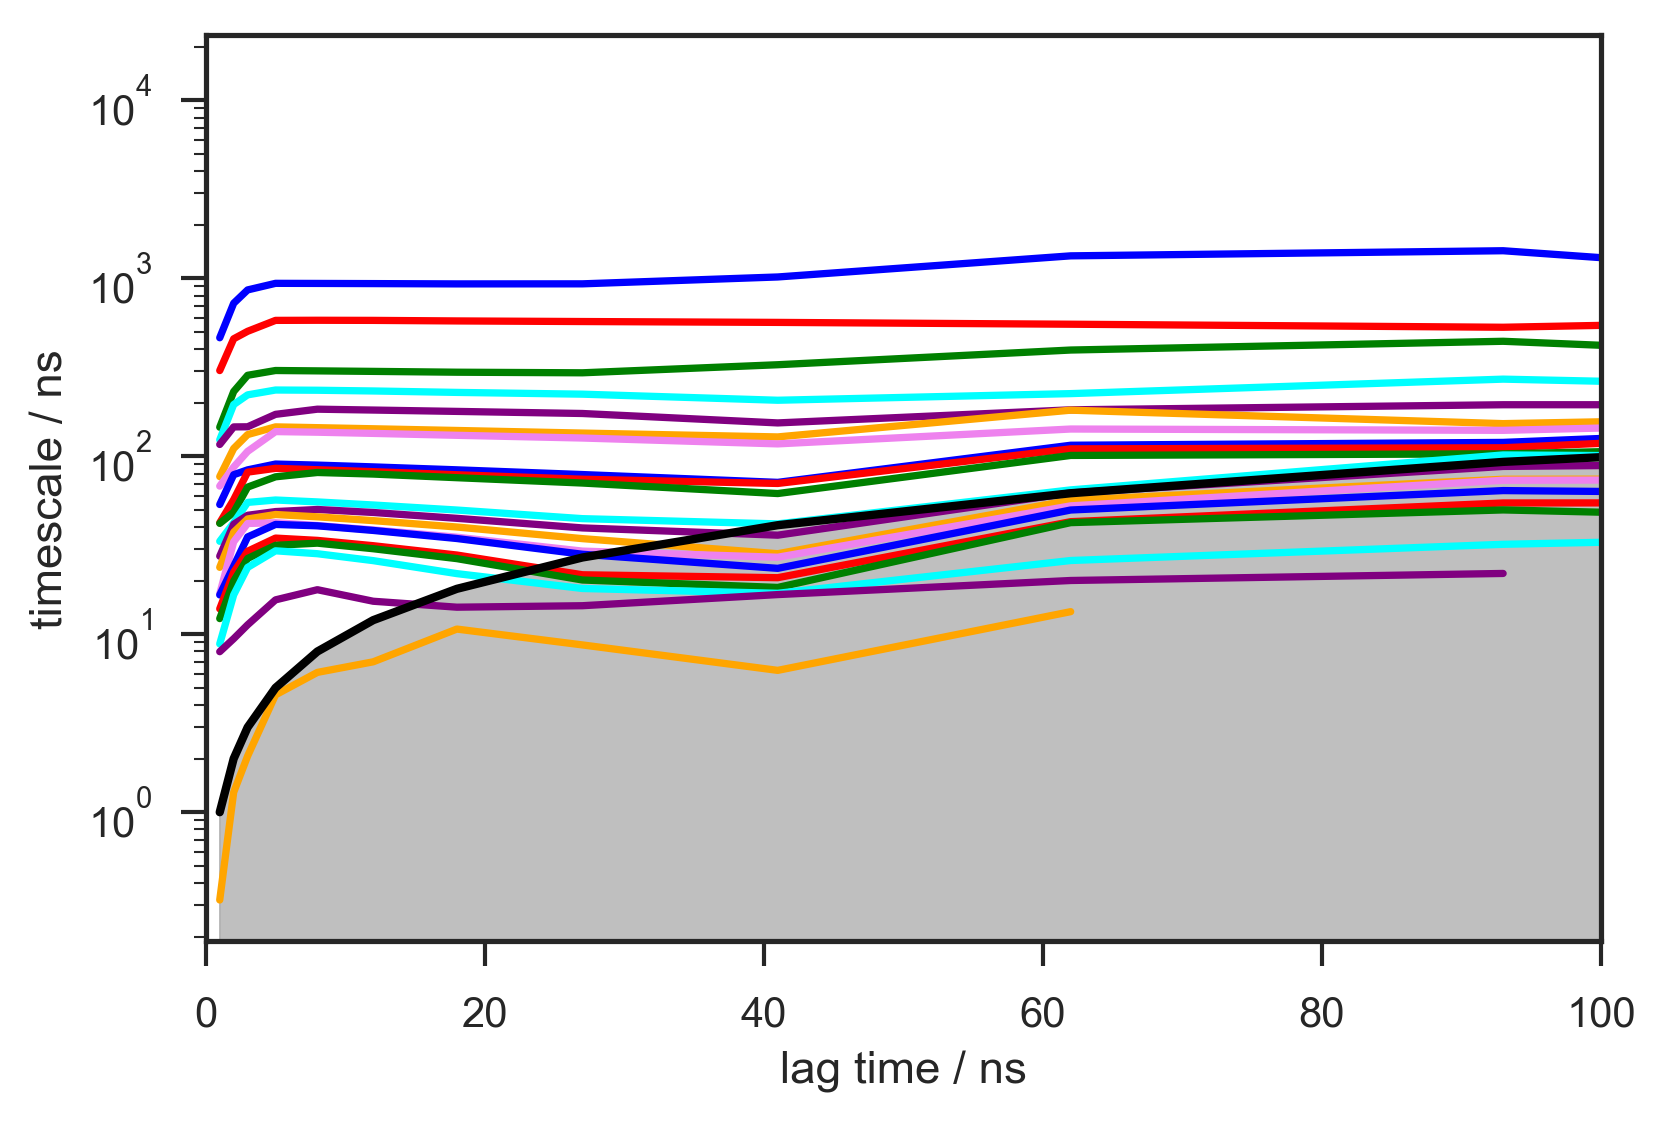

In [56]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(its, dt=1, units='ns')
plt.xlim(0,100)
plt.show()

In [ ]:
# these converge suspiciously fast - something to ponder - let's take 50 ns lag

In [57]:
# let's see the msm

In [66]:
msm = pyemma.msm.estimate_markov_model(dtrajs, lag=50)

In [67]:
msm.nstates

21

In [70]:
# only 21 out of 100 states are in the connected (active) set!! -- see which ones on the tica landscape

In [71]:
clusters = kmeans.cluster_centers_

In [ ]:
# all

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


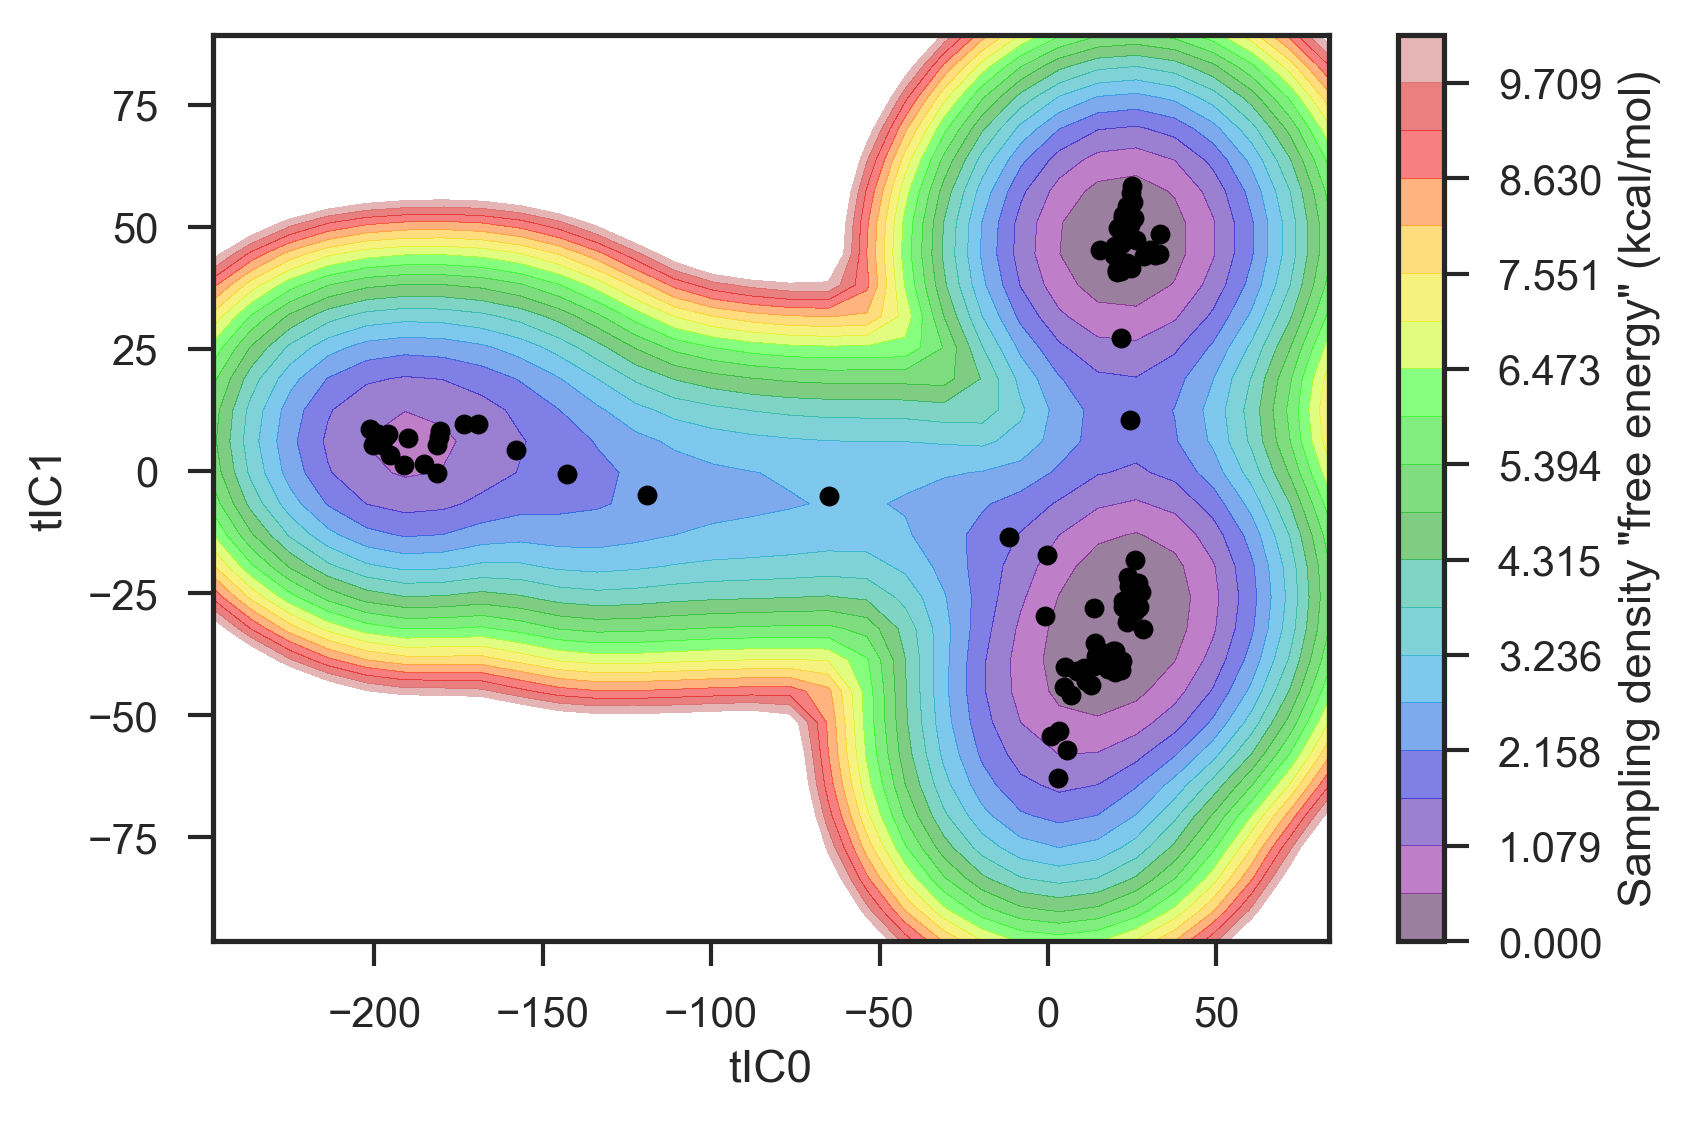

In [73]:
i=0
j=1

plot_data = msmexplorer.plot_free_energy(tica_proj_concat, obs=(i,j), cbar=True, return_data=True)
plt.close()

# plot initial conformations on it now
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
ax.grid(False)
ax.set_xlabel('tIC0')
ax.set_ylabel('tIC1')
vmin = -1E-12
vmax = np.percentile(plot_data[1][2], 50)
n_levels = 20
alpha = 0.5
im = ax.contourf(plot_data[1][0], plot_data[1][1], plot_data[1][2] - plot_data[1][2].min(),cmap=plt.get_cmap('spectral'),
                             levels=np.linspace(vmin, vmax, n_levels), alpha=alpha,
                             zorder=1, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Sampling density "free energy" (kcal/mol)')

for cluster in range(len(clusters)):
    plt.scatter(clusters[cluster][0], clusters[cluster][1], c='black', s=20)

#plt.savefig('tica/tics_0_1.png', dpi=300)
plt.show()

In [ ]:
# active set

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


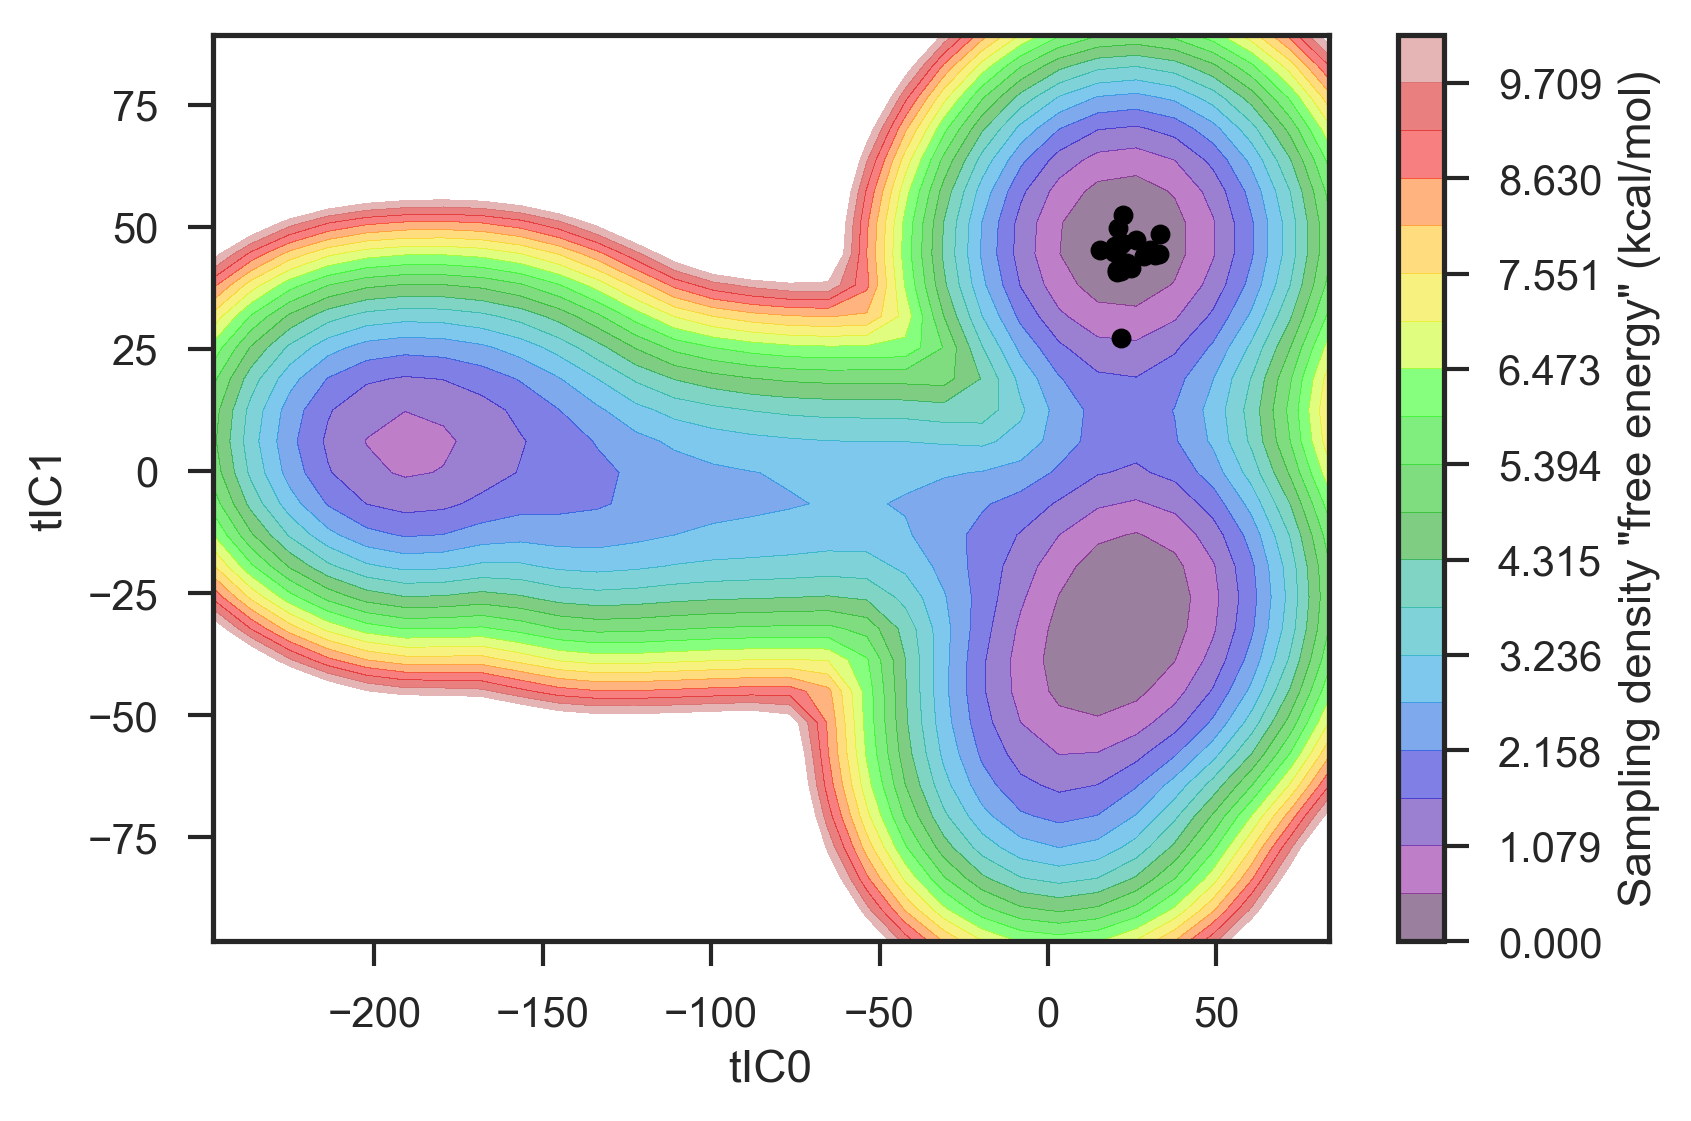

In [75]:
i=0
j=1

plot_data = msmexplorer.plot_free_energy(tica_proj_concat, obs=(i,j), cbar=True, return_data=True)
plt.close()

# plot initial conformations on it now
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1)
ax.grid(False)
ax.set_xlabel('tIC0')
ax.set_ylabel('tIC1')
vmin = -1E-12
vmax = np.percentile(plot_data[1][2], 50)
n_levels = 20
alpha = 0.5
im = ax.contourf(plot_data[1][0], plot_data[1][1], plot_data[1][2] - plot_data[1][2].min(),cmap=plt.get_cmap('spectral'),
                             levels=np.linspace(vmin, vmax, n_levels), alpha=alpha,
                             zorder=1, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Sampling density "free energy" (kcal/mol)')

for cluster in msm.active_set:
    plt.scatter(clusters[cluster][0], clusters[cluster][1], c='black', s=20)

#plt.savefig('tica/tics_0_1.png', dpi=300)
plt.show()

In [76]:
# let's see how the trajectories behave in tic0 and tic1

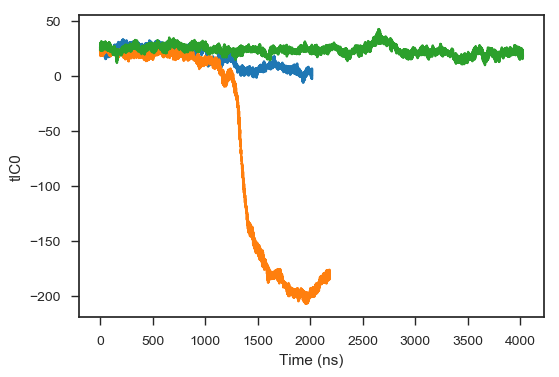

In [84]:
plt.figure(dpi=100)
plt.plot(Y[0][:,0])
plt.plot(Y[1][:,0])
plt.plot(Y[2][:,0])
plt.ylabel('tIC0')
plt.xlabel('Time (ns)')
plt.show()

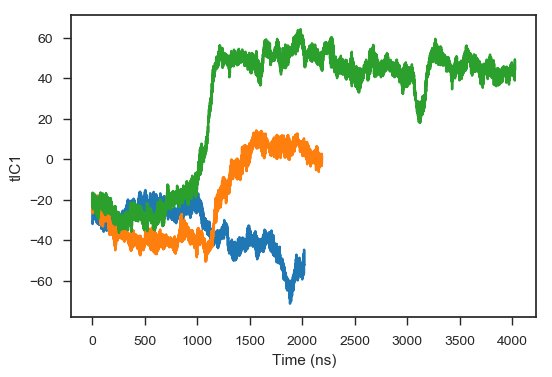

In [86]:
plt.figure(dpi=100)
plt.plot(Y[0][:,1])
plt.plot(Y[1][:,1])
plt.plot(Y[2][:,1])
plt.ylabel('tIC1')
plt.xlabel('Time (ns)')
plt.show()

In [ ]:
# IRREVERSIBLE TRANSITIONS IN BOTH TICS!!

In [ ]:
# I've scanned through further tics - tic4 appears ok, but then tic5 is not, tic6 is ok again

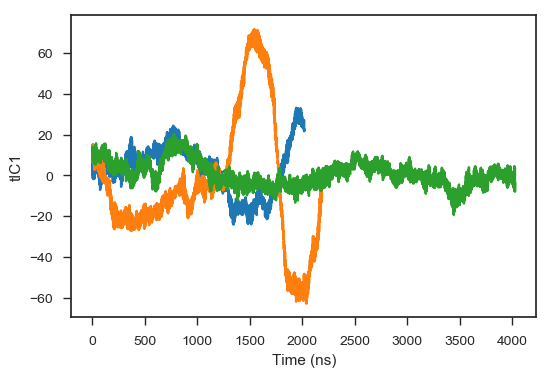

In [117]:
plt.figure(dpi=100)
plt.plot(Y[0][:,6])
plt.plot(Y[1][:,6])
plt.plot(Y[2][:,6])
plt.ylabel('tIC1')
plt.xlabel('Time (ns)')
plt.show()

In [ ]:
# DIAGNOSE - see which features tic0 is correlated with to examine trajectories and decide on "convergence"

In [135]:
corrs = apo_tica.feature_TIC_correlation

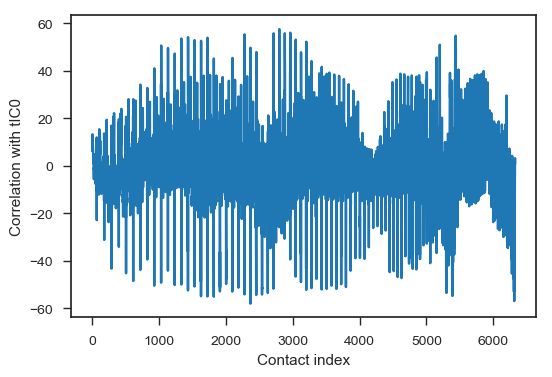

In [140]:
plt.figure(dpi=100)
plt.plot(corrs[:,0])
plt.ylabel('Correlation with tIC0')
plt.xlabel('Contact index')
plt.show()

In [147]:
apo1_contacts[1][np.argsort(np.abs(corrs[:,0]))[::-1]][:20] # indexes of residues for top 20 contacts

array([[ 23,  69],
       [ 28,  70],
       [107, 111],
       [ 30,  70],
       [ 29,  70],
       [ 27,  70],
       [ 22,  70],
       [ 17,  69],
       [ 16,  69],
       [ 15,  69],
       [ 70,  85],
       [ 69,  80],
       [ 69,  78],
       [ 69,  81],
       [ 24,  67],
       [ 13,  70],
       [ 25,  67],
       [ 22,  69],
       [ 16,  70],
       [ 70,  83]])

In [148]:
# for example let's look at the first one in the trajectories

In [154]:
np.argsort(np.abs(corrs[:,0]))[::-1][0]

2366

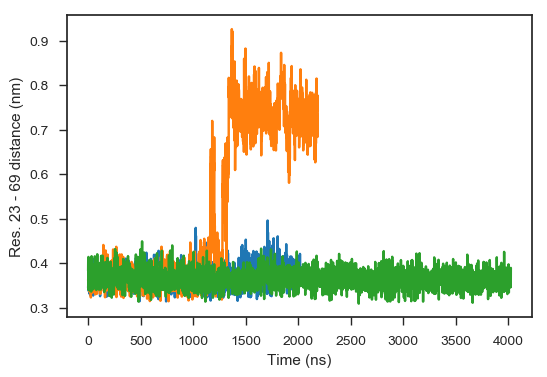

In [157]:
plt.figure(dpi=100)
plt.plot(apo1_contacts[0][:,2366])
plt.plot(apo2_contacts[0][:,2366])
plt.plot(apo3_contacts[0][:,2366])
plt.ylabel('Res. 23 - 69 distance (nm)')
plt.xlabel('Time (ns)')
plt.show()

In [ ]:
# inspecting trajectory 2 visually

In [159]:
apo2[0].save('apo2_top.pdb')
apo2.save('apo2.dcd')

In [118]:
# try not considering the top 5 tics

In [109]:
kmeans2 = pyemma.coordinates.cluster_kmeans([x[:,6:] for x in Y], k=100)

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=10), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

05-06-19 14:32:51 pyemma.coordinates.clustering.kmeans.KmeansClustering[13] INFO     Cluster centers converged after 6 steps.


In [110]:
dtrajs2 = kmeans2.get_output()
dtrajs2 = [np.concatenate(x) for x in dtrajs2]

HBox(children=(HBox(children=(Label(value='getting output of KmeansClustering'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=3), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [119]:
np.save('apo_fromtic6_100micro_dtrajs', dtrajs2)

In [111]:
msm2 = pyemma.msm.estimate_markov_model(dtrajs2, lag=50)

In [112]:
msm2.nstates

88

In [116]:
msm2.active_count_fraction

0.9031200679859172

In [ ]:
# this is acceptable

In [113]:
its = pyemma.msm.its(dtrajs2)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=18), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

05-06-19 14:33:08 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[16] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


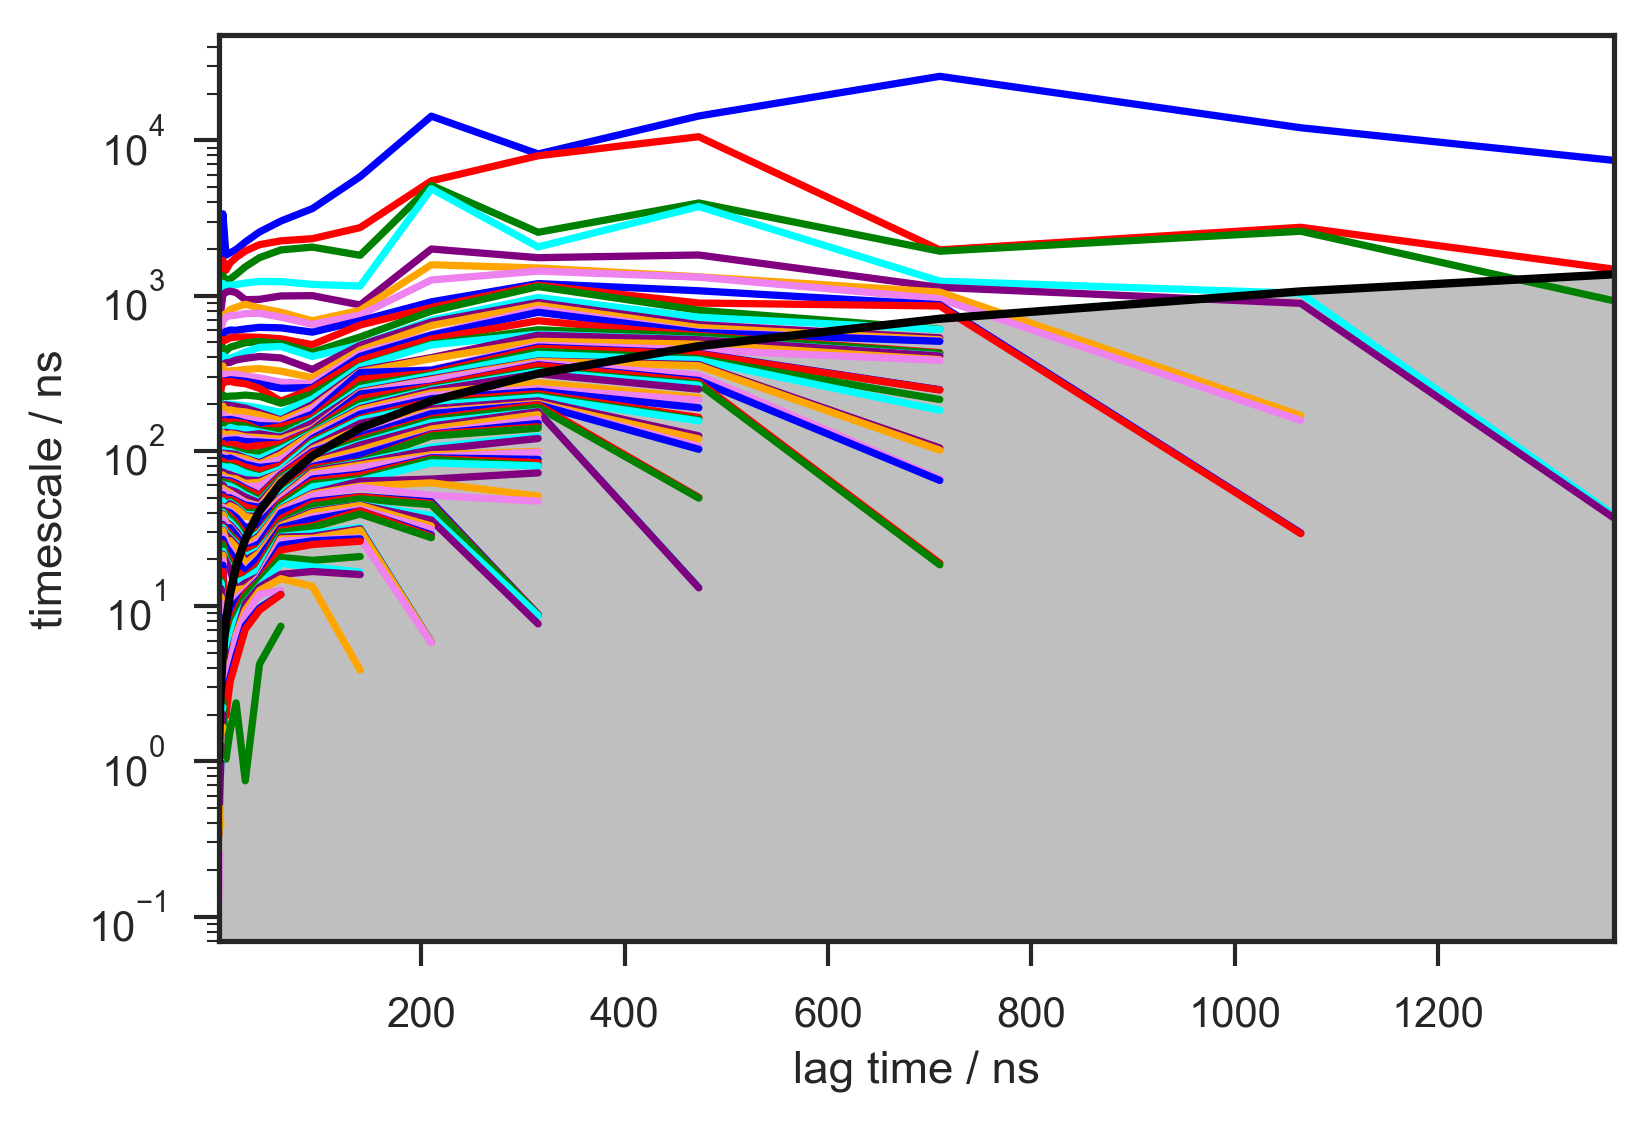

In [121]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(its, dt=1, units='ns')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


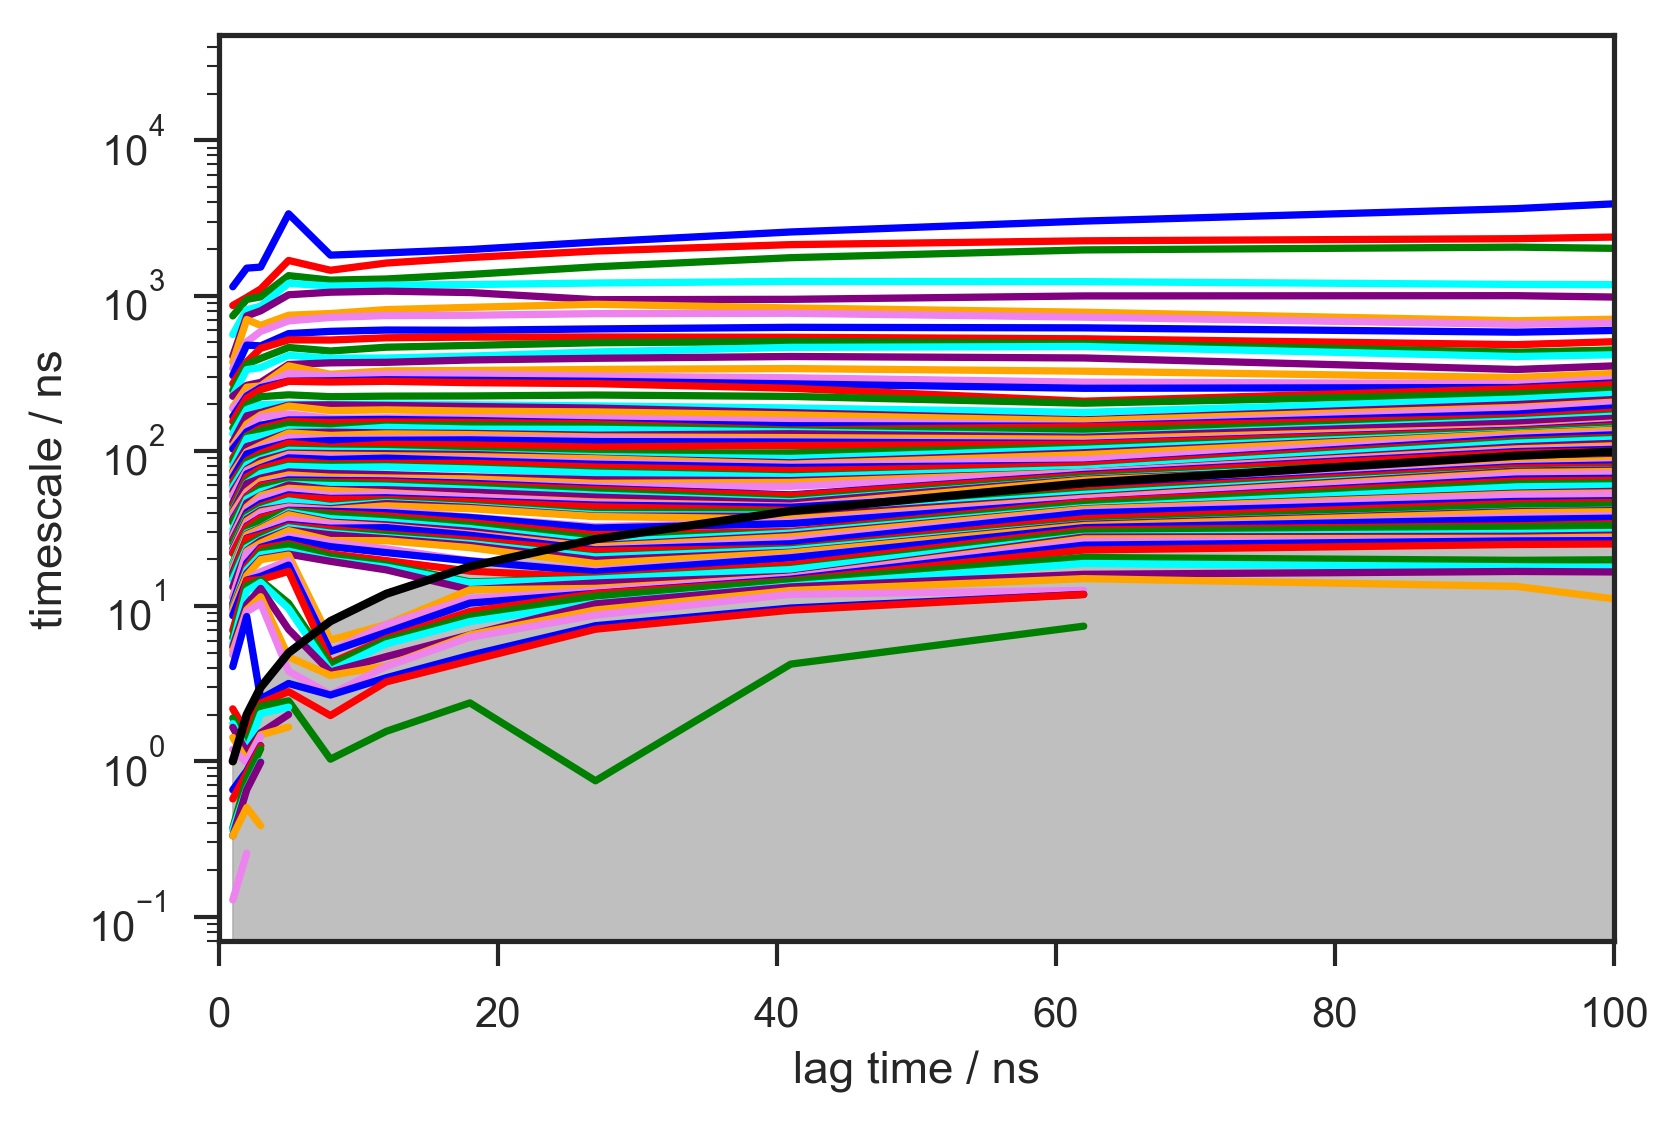

In [130]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(its, dt=1, units='ns')
plt.xlim(0,100)
plt.show()

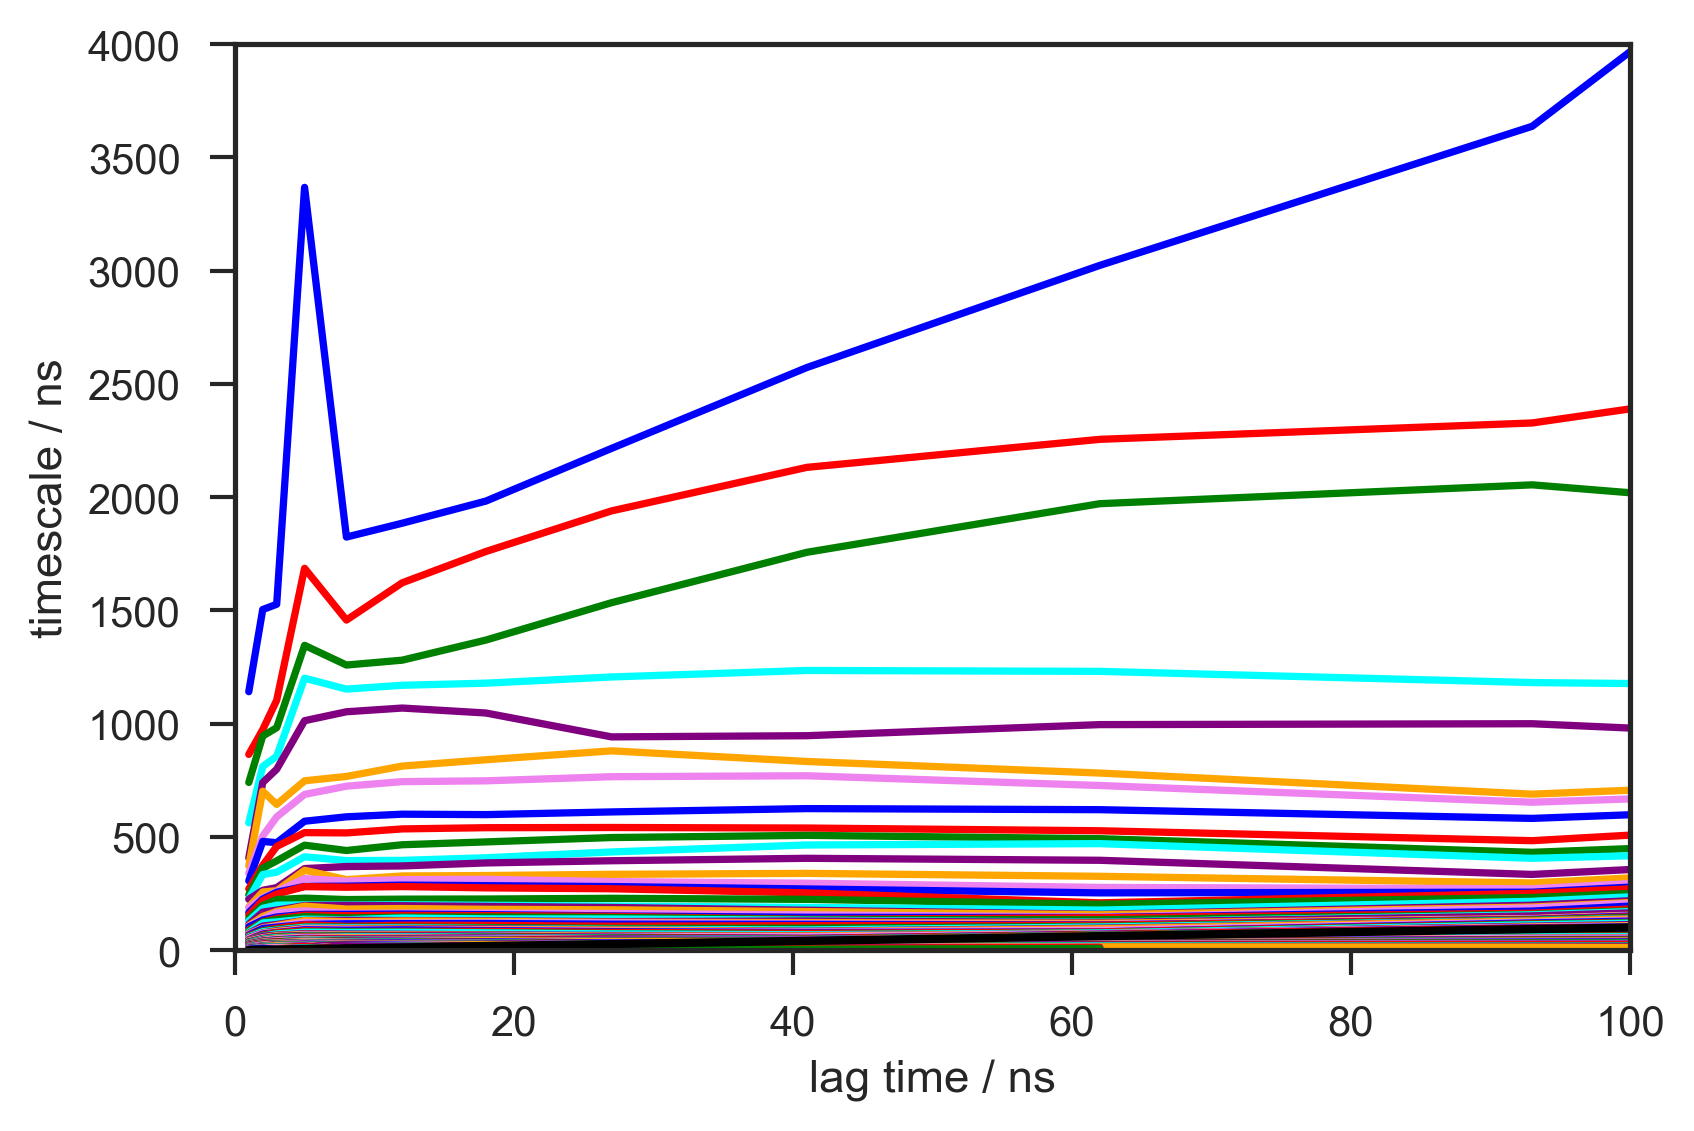

In [129]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(its, dt=1, units='ns', ylog=False)
plt.xlim(0,100)
plt.ylim(0,4000)
plt.show()

In [132]:
# let's see 2 macrostates

In [133]:
pcca = msm2.pcca(2)

In [134]:
pcca.coarse_grained_stationary_probability

array([0.31586778, 0.68413222])

In [161]:
# for visual analysis: a) see how the states switch in trajectories, b) see what distances are most correlated with
# the first eigenvector, i.e. difference between the two macrostates

In [162]:
pcca.metastable_sets

[array([ 2,  6,  7, 10, 13, 15, 16, 18, 19, 21, 23, 26, 31, 33, 38, 47, 48,
        51, 58, 61, 62, 73, 74, 80]),
 array([ 0,  1,  3,  4,  5,  8,  9, 11, 12, 14, 17, 20, 22, 24, 25, 27, 28,
        29, 30, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50,
        52, 53, 54, 55, 56, 57, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87])]

In [163]:
dtrajs_meta = []

for dtraj in dtrajs2:
    dtrajs_meta.append([])
    for state in dtraj:
        if state in pcca.metastable_sets[0]:
            dtrajs_meta[-1].append(0)
        elif state in pcca.metastable_sets[1]:
            dtrajs_meta[-1].append(1)
        else:
            dtrajs_meta[-1].append(2) # these will be the 12 microstates that are not in the active set (i.e. are irreversibly connected)

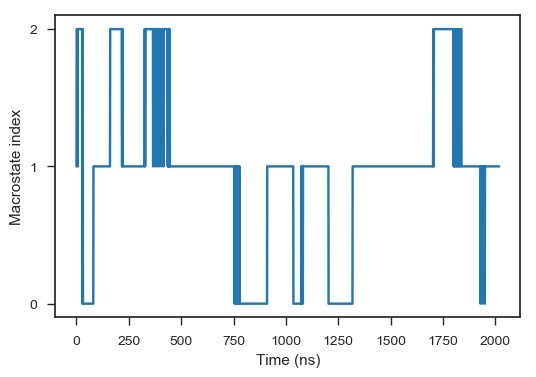

In [169]:
plt.figure(dpi=100)
plt.plot(dtrajs_meta[0])
#plt.plot(dtrajs_meta[1])
#plt.plot(dtrajs_meta[2])
plt.ylabel('Macrostate index')
plt.xlabel('Time (ns)')
plt.yticks([0,1,2])
plt.show()

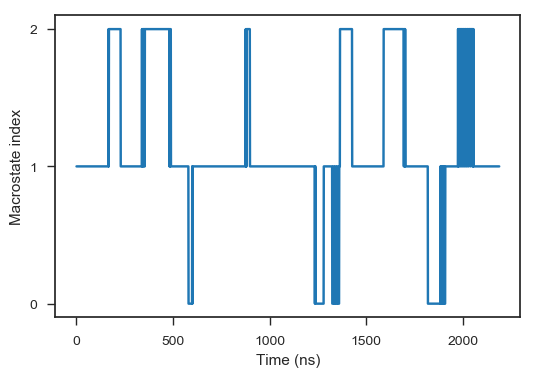

In [170]:
plt.figure(dpi=100)
#plt.plot(dtrajs_meta[0])
plt.plot(dtrajs_meta[1])
#plt.plot(dtrajs_meta[2])
plt.ylabel('Macrostate index')
plt.xlabel('Time (ns)')
plt.yticks([0,1,2])
plt.show()

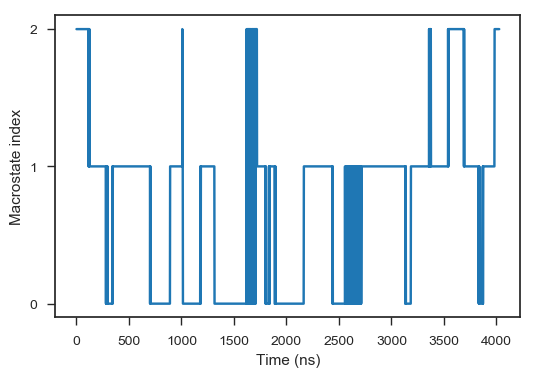

In [171]:
plt.figure(dpi=100)
#plt.plot(dtrajs_meta[0])
#plt.plot(dtrajs_meta[1])
plt.plot(dtrajs_meta[2])
plt.ylabel('Macrostate index')
plt.xlabel('Time (ns)')
plt.yticks([0,1,2])
plt.show()

In [174]:
# look at correlations with distances - we make a fake trajectory along the first eigenvector, then calculate R-squared

In [175]:
msm = msm2

In [181]:
eigen_traj = []

for state in np.argsort(msm.eigenvectors_right(2)[:,1]):
    eigen_traj.append(msm.active_state_indexes[state][np.random.choice(len(msm.active_state_indexes[state]), 100, replace=True)])
    
eigen_traj = np.concatenate(eigen_traj)

eigen_traj_dist = []

for x in eigen_traj:
    eigen_traj_dist.append([apo1_contacts[0], apo2_contacts[0], apo3_contacts[0]][x[0]][x[1]])
    
eigen_traj_dist = np.array(eigen_traj_dist)    

sorted_eigenv = msm.eigenvectors_right(2)[:,1][np.argsort(msm.eigenvectors_right(2)[:,1])]
sorted_eigenv = np.concatenate([[x]*100 for x in sorted_eigenv])

corr_coeffs = []

for i in range(apo1_contacts[0].shape[1]):
    corr_coeffs.append(np.corrcoef(sorted_eigenv, eigen_traj_dist[:,i])[0,1])

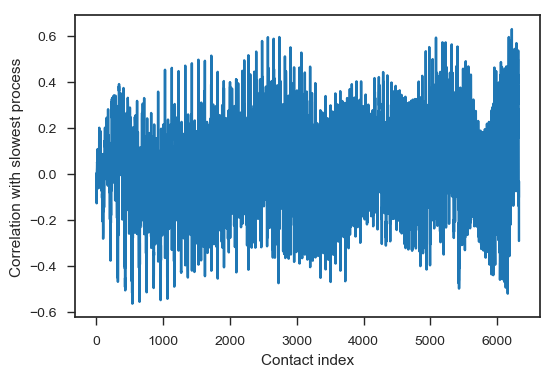

In [184]:
plt.figure(dpi=100)
plt.plot(corr_coeffs)
plt.ylabel('Correlation with slowest process')
plt.xlabel('Contact index')
plt.show()

In [185]:
apo1_contacts[1][np.argsort(np.abs(corr_coeffs))[::-1]][:20] # indexes of residues for top 20 contacts

array([[ 97, 112],
       [ 27,  97],
       [ 95,  98],
       [ 25,  97],
       [ 62,  97],
       [ 26,  97],
       [ 96, 112],
       [ 24,  97],
       [ 64,  97],
       [ 65,  97],
       [103, 112],
       [  4, 106],
       [ 67,  97],
       [  4, 108],
       [  5, 106],
       [  4, 107],
       [ 69,  97],
       [  5, 107],
       [ 60,  97],
       [ 29,  97]])

In [187]:
# IF YOU WANT TO GO AHEAD WITH THIS MODEL -- let's now see what the holo trajectories do in the same state space

In [189]:
holo_Y = apo_tica.transform([holo1_contacts[0], holo2_contacts[0]])

In [191]:
holo_Y = [x[:,6:3747] for x in holo_Y] # we're ignoring the first 5 tics also, and cutting off at 95% kinetic content

In [193]:
dtrajs_holo = kmeans2.transform(holo_Y)
dtrajs_holo = [np.concatenate(x) for x in dtrajs_holo]

In [197]:
np.save('holo_fromtic6_100micro_dtrajs', dtrajs_holo)

In [198]:
msm_holo = pyemma.msm.estimate_markov_model(dtrajs_holo, lag=50)

In [199]:
msm_holo.nstates

39

In [200]:
msm_holo.active_count_fraction

1.0

In [201]:
# holo populates only 39 microstates of the 100 apo ones and the active set containts all of them

In [203]:
its = pyemma.msm.its(dtrajs_holo)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=17), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

05-06-19 15:48:30 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[18] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


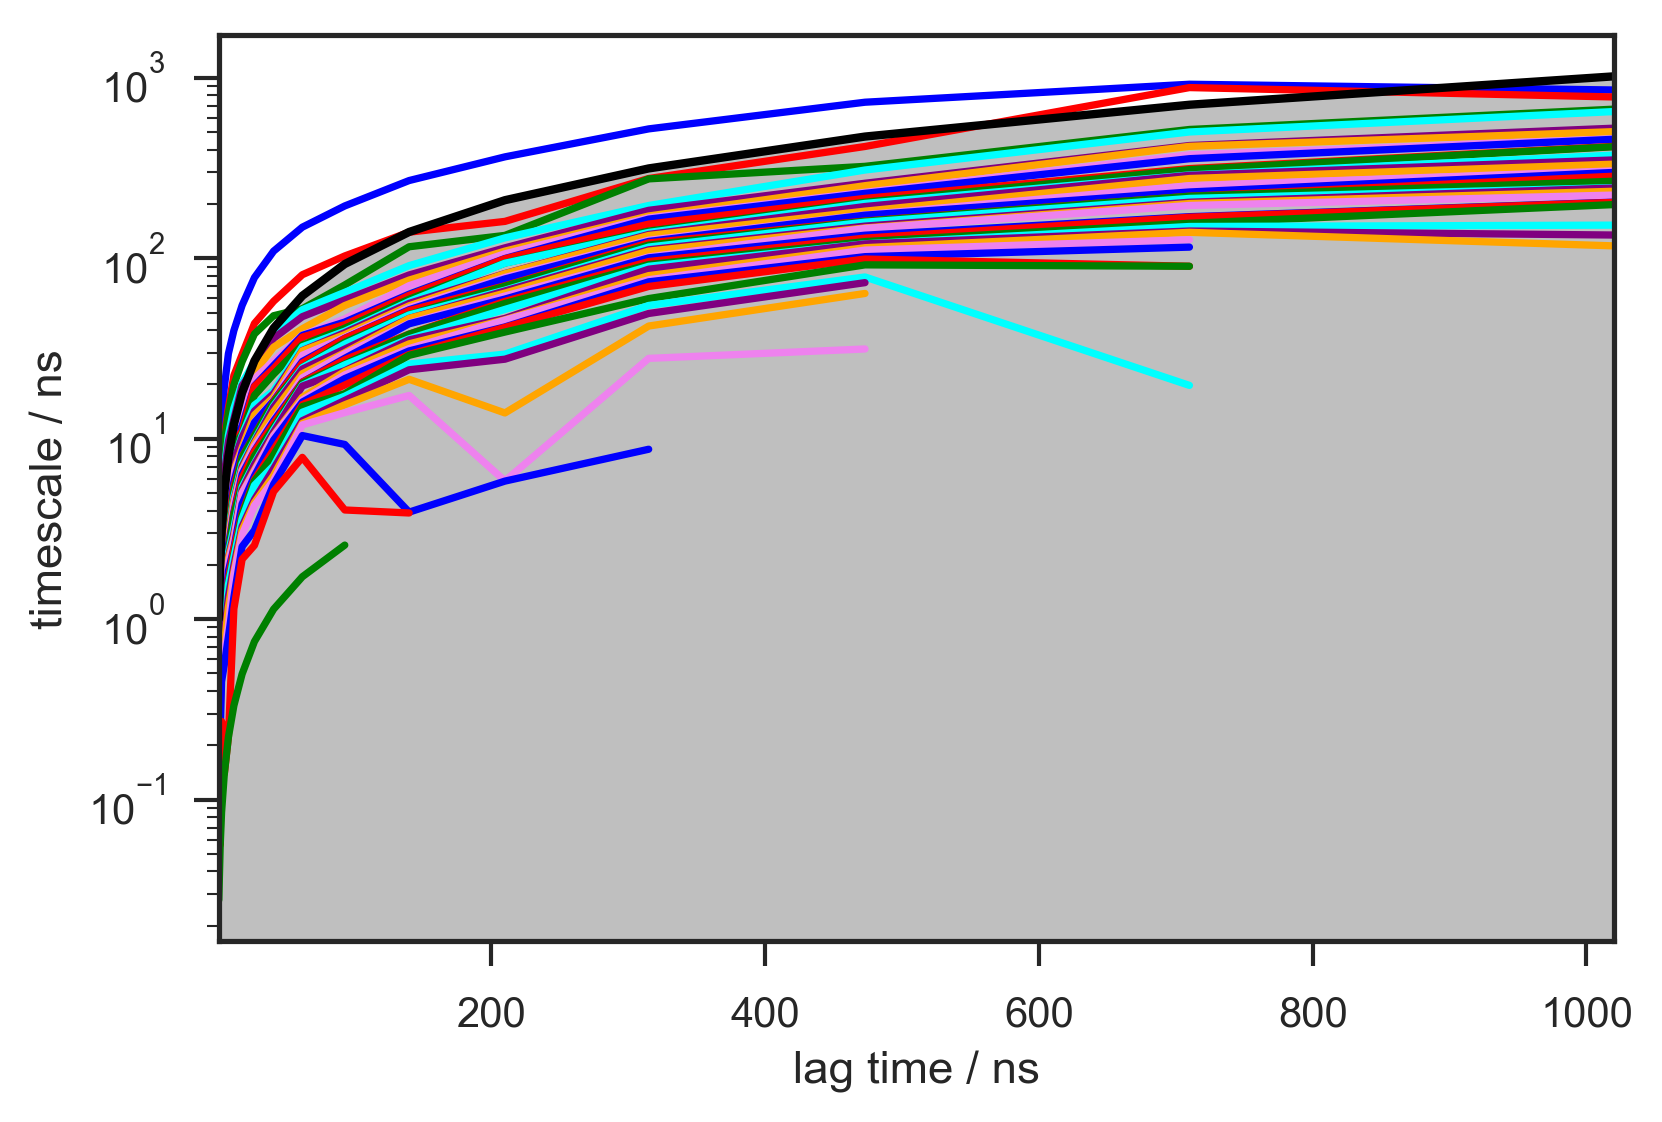

In [204]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(its, dt=1, units='ns')
plt.show()

In [205]:
# nothing slow in holo -- this either means we shouldn't use apo state space (and instead e.g. combined apo+holo state space)
# or that indeed there is no slow processes in holo - does it populate only one of the apo macrostates?

In [206]:
msm_holo.active_set

array([ 2,  3,  6,  7,  9, 10, 12, 15, 16, 18, 22, 27, 28, 31, 39, 44, 45,
       46, 48, 49, 52, 53, 54, 55, 61, 63, 66, 68, 74, 78, 80, 84, 87, 88,
       94, 95, 96, 97, 99])

In [207]:
pcca.metastable_sets

[array([ 2,  6,  7, 10, 13, 15, 16, 18, 19, 21, 23, 26, 31, 33, 38, 47, 48,
        51, 58, 61, 62, 73, 74, 80]),
 array([ 0,  1,  3,  4,  5,  8,  9, 11, 12, 14, 17, 20, 22, 24, 25, 27, 28,
        29, 30, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 49, 50,
        52, 53, 54, 55, 56, 57, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87])]

In [213]:
[x for x in msm_holo.active_set if x not in pcca.metastable_sets[0]]

[3,
 9,
 12,
 22,
 27,
 28,
 39,
 44,
 45,
 46,
 49,
 52,
 53,
 54,
 55,
 63,
 66,
 68,
 78,
 84,
 87,
 88,
 94,
 95,
 96,
 97,
 99]

In [214]:
[x for x in msm_holo.active_set if x not in pcca.metastable_sets[1]]

[2, 6, 7, 10, 15, 16, 18, 31, 48, 61, 74, 80, 88, 94, 95, 96, 97, 99]

In [ ]:
# we have a good deal of states from both apo macrostates, but not the slowness between them anymore - next step:
# once we have an idea of what features in the protein correspond to the macrostate switch in apo, look at the holo
# trajectories and see what they do